# INM707 Coursework
### Aaron Mir (Student Number: 160001207)


In [1]:
##--------------------Coding References---------------------## <img src="All_Tasks.png" alt="All_TasksOverview" width="700"/>  <img src="Task_1.png" alt="Task_1" width="700"/>
# Percentage of borrowed code: X% - 
# [1] 

***
## Stronghold

The robot agent is preparing for an upcoming mission in which they are to infiltrate an enemy stronghold to gather intelligence on a potential coup d'état. The enemy land is in the form of an NxN grid with each grid containing one stronghold of size N/2 x N or N x N/2 (starting on either side of the middle column (randomly decided)) and a wide river surrounding the entire enemy land. The stronghold has as many entrances from the mainland as (1/4)N and contains dangerous enemy combatants (at random positions) within the stronghold that move around randomly per step (stochasticity). The land inside the stronghold has no transition probability associated with it (deterministic). The land surrounding the stronghold (the shore) is booby-trapped and covered in mist which means that there is both land which can kill/hurt the agent as well as normal land and a transition probability (0.8 to move to the chosen state or 0.3 to move to another state) associated with each step (stochasticity) outside the stronghold. The amount of shore that has traps on it is (1/4)N x rows of shore. The row/column of values immediately beside the stronghold is normal land. The goal of the agent is to infiltrate the stronghold and gather the intelligence without being seen/killed by enemy combatants or booby traps.

This is a type of gridworld environment. The size (number of states) can be controlled by adjusting the grid dimensions. The environment is intended to model the process of navigating a frozen lake, while avoiding falling into holes with the objective of reaching a goal location. 

The environment is defined as follows:

- The environment is a rectangular grid of states/cells. There are five different types of cells as indicated by the following cell labels: 

    - _ labels cells that are safe to step on i.e. normal land [0]

    - X labels the cells that are walls i.e. river or wall and if the agent enters a wall cell, there is a penalty of -1 [1]
    
    - A labels the cell the agent is on, starts on a random cell on the shore [2]
    
    - T labels booby-trap cells and if the agent enters a booby-trap cell there is a pentalty of -1000 and the episode ends [3]

    - E labels enemy cells and if the agent enters an enemy cell there is a pentalty of -1000 and the episode ends [4]

    - I labels the intelligence cell and when reached gives a reward of 1000 and the episode ends [5]

- There are four possible actions (Up, Down, Left, Right). 

- The transition function moves the agent in the expected direction with 0.7 probability, and there is a 0.3 probability of transitioning to one of the other randomly selected directions. 

- There is a reward of -1 for each action taken by the agent, which is intended to encourage the agent to reach the goal as fast as possible. If the agent runs out of time, the episode ends. 

- Episodes end whenever the agent falls in a hole or reaches the goal. An end-of-episode is modeled by transitioning to a zero-reward terminal state (all actions lead to that state). 




State of the agent: Governed by the index of the cell it is on.

States of the environment: Governed by the index of the agent and the index of moving enemies.

Number of states of the environment is given by the size of the grid and the size of the stronghold in which enemies can move. e.g. for a 10x10 grid with a stronghold size of 6x3 and 6 enemies, the number of states is 100 - 6x3-1 +  (6x3-1 (because of starting state)/6)  - 1 (because of the intelligence in the stronghold)

Rewards/Penalties: +1000 for getting intelligence, -1000 for getting hurt by a combatant or booby trap, -1 for moving into a wall or water, -1 per transition because of fuel constraints

***

- FrozenLake.GetSuccessors() : Take a state and an action as input, and return a list of pairs, where each pair $(s',p)$ is a successor state $s'$ with non-zero probability and $p$ is the probability of transitioning to $p$.  

- FrozenLake.GetTransitionProb() : Take a state, an action, a next state as input, and return the probability of the transition 

- FrozenLake.GetReward() : Take a state and an action as input, and return the reward of that.

Observations will be fed into the dqn


Checklist:

The MDP consists of states, a transition probability, a reward function, and also actions

    1. Estabilish states (done, represented by the indices of the agent on the grid)
    2. Estabilish transitions matrix.
    3. Estabilish transition probability matrix. - deterministic right now
    3. Estabilish rewards matrix.
    4. Establish return G.
    5. Sort out enemy movement (done, enemies move within the stronghold)
    6. Implement partial observability
    7. Improve visualisation.

In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [113]:
class Stronghold():
    def __init__(self, size):
        self.size = size
        self.actions = {0: 'Up', 1: 'Down', 2: 'Left', 3: 'Right'}
        self.land = self.env_gen()
        self.position_agent = None                                 # initial position of the agent will be decided by resetting the environment
        self.time_elapsed = 0                                      # run time
        self.time_limit = self.size**2
        self.R = self.fill_reward_matrix()
        self.P = self.fill_transition_matrix()
        self.dict_map_display={ 0:'_',  # normal land
                                1:'X',  # river/wall
                                2:'A',  # agent
                                3:'T',  # trap
                                4:'E',  # enemy
                                5:'I'}  # intelligence
                    
    def env_gen(self):
        land = np.zeros((self.size, self.size))
        land[0,:] = 1                                               # establish the river
        land[:,0] = 1
        land[self.size-1,:] = 1
        land[:,self.size-1] = 1
        self.column_choice = np.random.choice((self.size//2-1, self.size//2+1)) # random choice whether stronghold starts from the left or right of the 'central' column
        land[1:self.size-1, self.column_choice] = 1
        if self.column_choice == self.size//2-1:                              # if stronghold is on left
            land[1, 0:self.column_choice] = 1                                # establish the walls of stronghold
            land[self.size-2, 0:self.column_choice] = 1
            land[1:self.size-1, 0] = 1                                   
            for col in land[1:self.size-1, self.column_choice+2:self.size-1].T:
                traps = []
                for i in range(int(np.round(1/4*len(col)))):        # make as many traps as 1/4 of the length of each column in the shore
                    trap = np.random.choice(np.setdiff1d(range(len(col)), traps))
                    col[trap] = 3
                    traps.append(trap)
            for col in land[2:self.size-2, 1:self.column_choice].T:
                enemies = []
                for i in range(int(np.round(1/4*len(col)))):        # populate enemies randomly inside the stronghold
                    enemy = np.random.choice(np.setdiff1d(range(len(col)), enemies))
                    col[enemy] = 4
                    enemies.append(enemy)
            #intel_row = np.random.randint(1, len(land[2:self.size-2, 1:self.column_choice-1]))
            #intel_col = np.random.randint(1, len(land[2:self.size-2, 1:self.column_choice-1].T))
            intel_row = np.random.randint(1, len(land[2:self.size-2]))
            intel_col = np.random.randint(1, len(land[1:self.column_choice-1]))
            land[intel_row+2][intel_col] = 5
            #land[intel_row+2][self.column_choice+intel_col] = 5
            #self.position_intel = [intel_row+2, self.column_choice+intel_col] 
            self.position_intel = [intel_row+2, intel_col]            # randomly insert intelligence into stronghold
        else:                                                              # if stronghold is on right                          
            land[1, self.column_choice:self.size] = 1
            land[self.size-2, self.column_choice:self.size] = 1
            land[1:self.size-1, self.size-1] = 1
            for col in land[1:self.size-1, 1:self.column_choice-1].T:
                traps = []
                for i in range(int(np.round(1/4*len(col)))):        # make as many traps as 1/4 of the length of each column in the shore
                    trap = np.random.choice(np.setdiff1d(range(len(col)), traps))
                    col[trap] = 3
                    traps.append(trap)
            for col in land[2:self.size-2, self.column_choice+1:self.size-1].T:
                enemies = []
                for i in range(int(np.round(1/4*len(col)))):        # populate enemies randomly inside the stronghold
                    enemy = np.random.choice(np.setdiff1d(range(len(col)), enemies))
                    col[enemy] = 4
                    enemies.append(enemy)
            # intel_row = np.random.randint(1, len(land[2:self.size-2, self.column_choice+1:self.size-1]))              
            # intel_col = np.random.randint(1, len(land[2:self.size-2, self.column_choice+1:self.size-1].T))
            # land[intel_row+2][self.column_choice+intel_col] = 5
            # self.position_intel = [intel_row+2, self.column_choice+intel_col]             # randomly insert intelligence into stronghold
            intel_row = np.random.randint(1, len(land[2:self.size-2]))              
            intel_col = np.random.randint(1, len(land[self.column_choice+1:self.size-1]))
            land[intel_row+2][self.column_choice+intel_col] = 5
            self.position_intel = [intel_row+2, self.column_choice+intel_col]             # randomly insert intelligence into stronghold
        entrances = []
        for i in range(int(np.round(1/4*len(land[2:self.size-2, self.column_choice])))):        # make as many entrances as 1/4 of the length of the front wall 
            entrance = np.random.choice(np.setdiff1d(range(len(land[2:self.size-2, self.column_choice])), entrances))
            land[2:self.size-2, self.column_choice][entrance] = 0
            entrances.append(entrance)
        return land
        
    def normal_shore(self, n_cells):
        if self.column_choice == self.size//2-1:
            empty_cells_coord = np.where(self.land[1:self.size-1, self.column_choice+1:self.size-1] == 0)
            selected_indices = np.random.choice(np.arange(len(empty_cells_coord[0])), n_cells)
            selected_coordinates = empty_cells_coord[0][selected_indices]+1, empty_cells_coord[1][selected_indices]+len(self.land[1][:self.column_choice+1])
        if self.column_choice == self.size//2+1:
            empty_cells_coord = np.where(self.land[1:self.size-1, 1:self.column_choice] == 0)
            selected_indices = np.random.choice(np.arange(len(empty_cells_coord[0])), n_cells)
            selected_coordinates = empty_cells_coord[0][selected_indices]+1, empty_cells_coord[1][selected_indices]+1
        if n_cells == 1:
            return np.asarray(selected_coordinates).reshape(2,)
        return selected_coordinates

    def step(self, action):
        # enemies move randomly - they do not move if their choice is a wall, the intelligence, another enemy or the stronghold entrance column
        for i, j in zip(*np.where(self.land == 4)):
            move = np.random.choice(('up', 'down', 'left', 'right'))
            if move == 'up' and self.land[i-1][j] != 1 and self.land[i-1][j] != 4 \
                and self.land[i-1][j] != 5:
                self.land[i][j] = 0
                self.land[i-1][j] = 4
            if move == 'down' and self.land[i+1][j] != 1 and self.land[i+1][j] != 4 \
                and self.land[i+1][j] != 5:
                self.land[i][j] = 0
                self.land[i+1][j] = 4
            if move == 'left' and self.land[i][j-1] != 1 and self.land[i][j-1] != 4 \
                and self.land[i][j-1] != 5 and j-1 != self.column_choice:
                self.land[i][j] = 0
                self.land[i][j-1] = 4
            if move == 'right' and self.land[i][j+1] != 1 and self.land[i][j+1] != 4 \
                and self.land[i][j+1] != 5 and j+1 != self.column_choice:
                self.land[i][j] = 0
                self.land[i][j+1] = 4
        
        # agent moves
        current_position = np.array((self.position_agent[0], self.position_agent[1])) # saving the current position in case agent hits a wall
        reward_step = 0
        if action == 'up':                                          # action is 'up', 'down', 'left', or 'right'
            self.position_agent[0] -= 1   
        if action == 'down':
            self.position_agent[0] += 1 
        if action == 'left':
            self.position_agent[1] -= 1
        if action == 'right':
            self.position_agent[1] += 1

        # calculate total reward
        if self.land[self.position_agent[0]][self.position_agent[1]] == 1:
            reward_step -= 1
            self.position_agent = current_position                                                         
        if self.land[self.position_agent[0]][self.position_agent[1]] == 3 or self.land[self.position_agent[0]][self.position_agent[1]] == 4:
            reward_step -= 100
        if self.land[self.position_agent[0]][self.position_agent[1]] == 5:
            reward_step += 10
            done = True                     # termination condition

        # implement transition probabilities 
        
        prob_of_tripping = [0.7, 0.1, 0.1, 0.1] # 0.7 probability of going to where it chooses and 0.3 to go to differently

        # calculate observations
        observations = self.observations()
        
        # time-limit termination condition
        if self.time_elapsed == self.time_limit:
            done = True
        else:
            done = False
            self.time_elapsed += 1              # update time
            reward_step -= 1                    # negative reward per time-step
        
        new_state = self.state_transition_matrix[self.position_agent[0]][self.position_agent[1]][self.actions[action]]

        # update visualisation
        im.set_data()
        return new_state, reward, done
    
    def observations(self):  
        proximity = self.land[self.position_agent[0]-1: self.position_agent[0]+2,
                                self.position_agent[1] -1: self.position_agent[1] +2]
        observations = {'relative intel coords': self.position_intel - self.position_agent, 'proximity': proximity}
        return observations

    def reset(self):
        self.time_elapsed = 0                                              # put time_elapsed to 0
        self.position_agent = np.asarray(self.normal_shore(1))             # position of the agent is a random cell on the shore
        
        # Calculate observations
        observations = self.observations()
        return observations

    def render(self):                                                       # displays the lanD
        envir_with_agent = self.land.copy()
        envir_with_agent[self.position_agent[0], self.position_agent[1]] = 2
        
        fig, ax = plt.subplots(figsize=(10, 10))
        im = ax.imshow(envir_with_agent) 

        ax.set_xticks(np.arange(len(envir_with_agent)))
        ax.set_yticks(np.arange(len(envir_with_agent)))

        # Loop over data dimensions and create text annotations.
        for i in range(len(envir_with_agent)):
            for j in range(len(envir_with_agent)):
                if envir_with_agent[i, j] == 0:
                    text = ""
                elif envir_with_agent[i, j] == 1:
                    text = "X"
                elif envir_with_agent[i, j] == 2:
                    text = "A"
                elif envir_with_agent[i, j] == 3:
                    text = "T"
                elif envir_with_agent[i, j] == 4:
                    text = "E"
                elif envir_with_agent[i, j] == 5:
                    text = "I"
                else:
                    text = ""    
                text_cell = ax.text(j, i, text, ha="center", va="center", color="w", fontsize='xx-large')

        ax.set_title("Stronghold")
        fig.tight_layout()
        plt.axis('off')
        plt.show()

    def fill_transition_matrix(self):
        state_transition_matrix = []
        for i in range(len(self.land)):
            for j in range(len(self.land)):
                if i-1 < 0:
                    state_up = None
                else: state_up = np.array([i-1, j])
                if i+1 > len(self.land)-1:
                    state_down = None
                else: state_down = np.array([i+1, j])
                if j-1 < 0:
                    state_left = None
                else: state_left = np.array([i, j-1])
                if j+1 > len(self.land)-1:
                    state_right = None
                else: state_right = np.array([i, j+1])
                state_transition_matrix.append([state_up, state_down, state_left, state_right])
        state_transition_array = np.array(state_transition_matrix, dtype=object).reshape(self.size*self.size, 4) # used to be 1 at the end
        P = np.vsplit(state_transition_array, self.size) # P maps the position of the agent (the state) and action to reachable states - N*N is number of reachable states, 4 is number of possible actions 
        return P
        
    def fill_reward_matrix(self): # change the values to reward values?
        reward_matrix = []
        for i in range(len(self.land)):
            for j in range(len(self.land)):
                if i-1 < 0:
                    reward_up = None
                else: reward_up = self.land[i-1][j]
                if i+1 > len(self.land)-1:
                    reward_down = None
                else: reward_down = self.land[i+1][j]
                if j-1 < 0:
                    reward_left = None
                else: reward_left = self.land[i][j-1]
                if j+1 > len(self.land)-1:
                    reward_right = None
                else: reward_right = self.land[i][j+1]
                reward_matrix.append([reward_up, reward_down, reward_left, reward_right])
        reward_array = np.array(reward_matrix).reshape(self.size*self.size, 4) 
        R = np.vsplit(reward_array, self.size) # R maps the position of the agent (the state) and action to rewards - currently displays the obstacles but can be changed to rewaerd values
        return R
############################################
    def evaluate_policy(self, policy, trials = 1000):
        total_reward = 0
        for _ in range(trials):
            self.reset()
            done = False
            observation, reward, done, info = self.step(policy[0])
            total_reward += reward
            while not done:
                observation, reward, done, info = self.step(policy[observation])
                total_reward += reward
        return total_reward / trials

    def evaluate_policy_discounted(env, policy, discount_factor, trials = 1000):
        total_reward = 0
        #INSERT YOUR CODE HERE
        for _ in range(trials):
            env.reset()
            done = False
            observation, reward, done, info = self.step(policy[0])
            beta = 1
            total_reward += (reward * beta)
            while not done: 
                observation, reward, done, info = self.step(policy[observation])
                beta *= discount_factor
                total_reward += (beta * reward)
        return total_reward / trials

In [114]:
# the state of the agent is entirely described by either the coordinates of the cell it is on, or the index of the cell.
# the value function (can be represented as a dictionary, or an array) that maps the state to the value of the state. As we don't know the true value at the beginning, it will be initialized at 1.
# the current state is given by self.position_agent gives the state i.e. its index
# the actions will be the direct cells that an agent can go to from a particular cell or up down left right
# the rewards will be given to a robot if a cell/state is directly reachable from the current state.

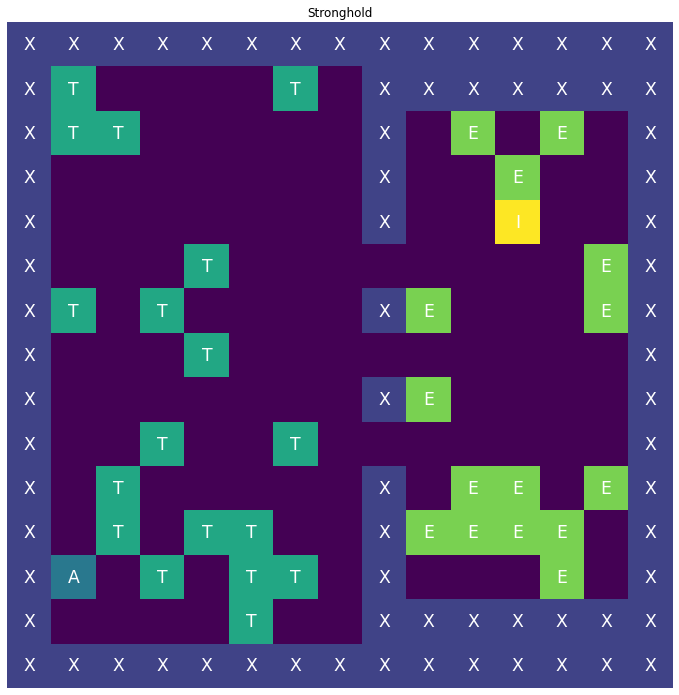

In [124]:
stronghold = Stronghold(15)
stronghold.reset()
stronghold.render()

In [12]:
stronghold.P[13][12]

array([array([12, 12]), array([14, 12]), array([13, 11]), array([13, 13])],
      dtype=object)

In [13]:
stronghold.R[13][12]

array([0.0, 4.0, 0.0, 0.0], dtype=object)

In [16]:
stronghold.land[0][0]

1.0

In [37]:
stronghold.P[9][4]

array([array([8, 4]), None, array([9, 3]), array([9, 5])], dtype=object)

In [38]:
stronghold.R[9][4]

array([1.0, None, 1.0, 1.0], dtype=object)

In [16]:
class Policies():
    def __init__(self):
        pass
    
    def random_policy(self):
        pass

# Ignore

In [ ]:
   def fill_transition_probability_matrix(self):
        state_transition_matrix = []
        for i in range(len(self.land)):
            for j in range(len(self.land)):
                if i-1 < 0:
                    state_up = None
                elif self.land[i][j] == 0: 
                    state_up = np.array([[i-1, j], 1.0])
                elif self.land[i][j] == 1: 
                    state_up = np.array([[i-1, j], 1.0])
                elif self.land[i][j] == 3: 
                    state_up = np.array([[i-1, j], 1.0])
                elif self.land[i][j] == 4: 
                    state_up = np.array([[i-1, j], 1.0])
                elif self.land[i][j] == 5: 
                    state_up = np.array([[i-1, j], 1.0])
                
                if i+1 > len(self.land)-1:
                    state_down = None
                elif self.land[i][j] == 0: 
                    state_down = np.array([[i+1, j], 1.0])
                elif self.land[i][j] == 1: 
                    state_down = np.array([[i+1, j], 1.0])
                elif self.land[i][j] == 3: 
                    state_down = np.array([[i+1, j], 1.0])
                elif self.land[i][j] == 4: 
                    state_down = np.array([[i+1, j], 1.0])
                elif self.land[i][j] == 5: 
                    state_down = np.array([[i+1, j], 1.0])
                
                if j-1 < 0:
                    state_left = None
                elif self.land[i][j] == 0: 
                    state_left = np.array([[i, j-1], 1.0])
                elif self.land[i][j] == 1: 
                    state_left = np.array([[i, j-1], 1.0])
                elif self.land[i][j] == 3: 
                    state_left = np.array([[i, j-1], 1.0])
                elif self.land[i][j] == 4: 
                    state_left = np.array([[i, j-1], 1.0])
                elif self.land[i][j] == 5: 
                    state_left = np.asarray([[i, j-1], 1.0])
            
                if j+1 > len(self.land)-1:
                    state_right = None
                elif self.land[i][j] == 0: 
                    state_right = np.array([[i, j+1], 1.0])
                elif self.land[i][j] == 1: 
                    state_right = np.array([[i, j+1], 1.0])
                elif self.land[i][j] == 3: 
                    state_right = np.array([[i, j+1], 1.0])
                elif self.land[i][j] == 4: 
                    state_right = np.array([[i, j+1], 1.0])
                elif self.land[i][j] == 5: 
                    state_right = np.array([[i, j+1], 1.0])
                state_transition_matrix.append([state_up, state_down, state_left, state_right])
        state_transition_array = np.array(state_transition_matrix).reshape(self.size*self.size, 4) # used to be 1 at the end
        det_P = np.vsplit(state_transition_array, self.size) # deterministic version of P